In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

import datetime
from datetime import datetime, timedelta
# from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#### EDA: Process Historical Data & Fit the model

In [3]:
## Import histroical data from 2021-05-28 to 2023-04-30
df = pd.read_csv("data.csv")
df.head()

,date,display,social,search,revenue,tv,promo
0,5/28/2021,0.0,2873.97,0.0,12562.66,0,0
1,5/29/2021,0.0,9760.51,0.0,130316.75,0,0
2,5/30/2021,0.0,9305.28,0.0,143059.94,0,0
3,5/31/2021,0.0,9747.94,0.0,305014.36,0,0
4,6/1/2021,0.0,9694.53,0.0,329041.17,0,0


In [4]:
#### Aggregate daily data to weekly for better predications #### 
################################################################ 
df['date'] = pd.to_datetime(df['date'])

## get weekstart (Monday)
def this_monday(date):
    return datetime.strftime(date-timedelta(date.weekday()),"%Y-%m-%d")

weekstart = []
for i in df['date']:
    weekstart.append(this_monday(i))

df['week'] = weekstart

## group by week
df_sum=pd.pivot_table(df, index=['week'], values=['display','social','search','revenue'],aggfunc=np.sum)
df_max=pd.pivot_table(df, index=['week'], values=['tv','promo'],aggfunc=np.max)
df = pd.merge(df_sum, df_max, left_index=True, right_index=True)

########################  Add time features #################### 
################################################################ 
df['week'] = df.index
df['week'] = pd.to_datetime(df.week, format='%Y-%m-%d')
df['year'] = df['week'].dt.year
df['year'] = df['year']-2020
# df['quarter'] = df['week'].dt.quarter
# df['month'] = df['week'].dt.month
# df['dayofweek'] = df['date'].dt.dayofweek
# df['dayofyear'] = df['date'].dt.dayofyear
# df['dayofmonth'] = df['date'].dt.day
# df['weekofyear'] = df['week'].dt.isocalendar().week
df = df.drop(columns = 'week')

########################  Check Correlation #################### 
################################################################ 
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
#Based on the corr plot, only keep 'Year'

########################  categorize dummy variables #################### 
################################################################ 
df['promo'] = df['promo'].astype("category")
df['tv'] = df['tv'].astype("category")

# df = df.drop(columns = ['tv','promo'])
df.head()

,display,revenue,search,social,promo,tv,year
week,,,,,,,
2021-05-24,0.000000,285939.35,0.0,21939.76,0,0,1
2021-05-31,0.000000,1566404.94,0.0,43350.00,0,0,1
2021-06-21,23653.256416,1051735.48,0.0,57565.44,0,0,1
2021-06-28,26925.044757,1296185.47,0.0,74953.23,0,0,1
2021-07-05,28697.446062,1715993.51,0.0,75982.04,0,0,1


<AxesSubplot:>

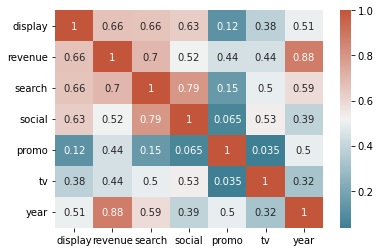

In [5]:
##check correlations
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot:>

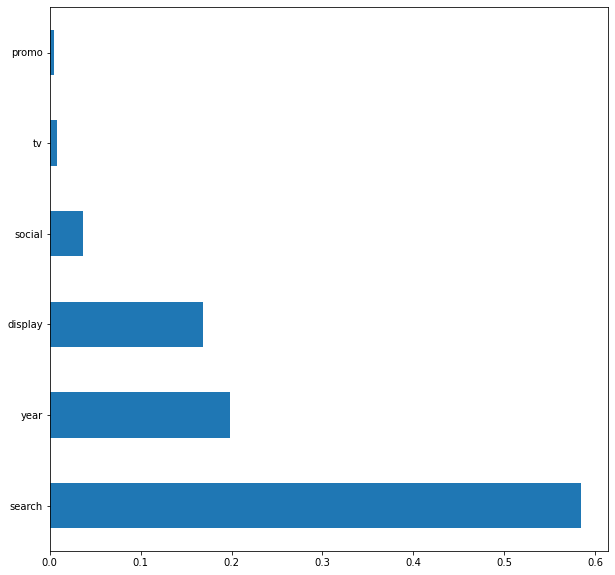

In [6]:
##Check Featuer Importance

# Setting X and y variables
X = df.loc[:, ~df.columns.isin(['revenue', 'date'])]
y = df['revenue']
# Building Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae,r2_score
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0,shuffle = True)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

<AxesSubplot:xlabel='week'>

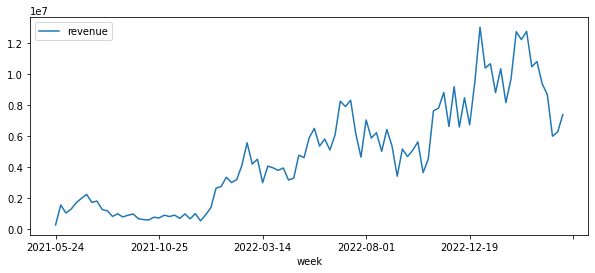

In [7]:
## see historical trend
df[['revenue']].plot(figsize=(10, 4))

In [8]:
#### Train/Test Split 80%/20% on 2023
y = df['revenue']
X = df.drop(columns = 'revenue')

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

In [9]:
#### Pick model based on performance
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

# head = 10
# for model in regressors[:head]:
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.8579609177008202
	Mean absolute error: 951005.79628
	R2 score: 0.8455590283189947

GradientBoostingRegressor()
	Training time: 0.017s
	Prediction time: 0.001s
	Explained variance: 0.8732681117145863
	Mean absolute error: 990424.2844471873
	R2 score: 0.8730484529225078

KNeighborsRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.8579609177008202
	Mean absolute error: 951005.79628
	R2 score: 0.8455590283189947

ExtraTreesRegressor()
	Training time: 0.047s
	Prediction time: 0.006s
	Explained variance: 0.9230050084111625
	Mean absolute error: 792834.9631420005
	R2 score: 0.9226692701660213

RandomForestRegressor()
	Training time: 0.066s
	Prediction time: 0.006s
	Explained variance: 0.9154964285169891
	Mean absolute error: 893338.066332501
	R2 score: 0.915395064802646

DecisionTreeRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.8040

#### Forecast on Test Set

Accuracy 0.8381891897666308
MAPE: 0.2283855301998575
R2 0.927804809239381


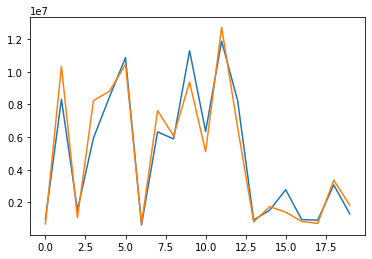

In [10]:
### Predict & plot
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_test = y_test.reset_index(drop=True)

y_pred = np.array(y_pred).tolist()

plt.plot(y_pred)
plt.plot(y_test)

### Check Error Scores

#Accuracy
abs_error = abs(y_test - y_pred)
accuracy = 1 - abs_error.sum()/y_test.sum()
# google_mae = mean_absolute_error(y_true=df_test['revenue'],
#                    y_pred=df_test['revenue_pred'])
# df_mse = mean_squared_error(y_true=df_test['revenue'],
#                    y_pred=df_test['revenue_pred'])
df_mape = mean_absolute_percentage_error(y_true=y_test,
                               y_pred=y_pred)

print('Accuracy {}'.format(accuracy))
# print('MAE: {}'.format(google_mae))
# print('MSE: {}'.format(df_mse))
print('MAPE: {}'.format(df_mape))
# print('RMSE: {}'.format(df_rmse))
print('R2 {}'.format(r2_score(y_test, y_pred)))

Accuracy 0.9680261862992797
R2 0.9801430636806346
MAPE: 0.045722636251862306


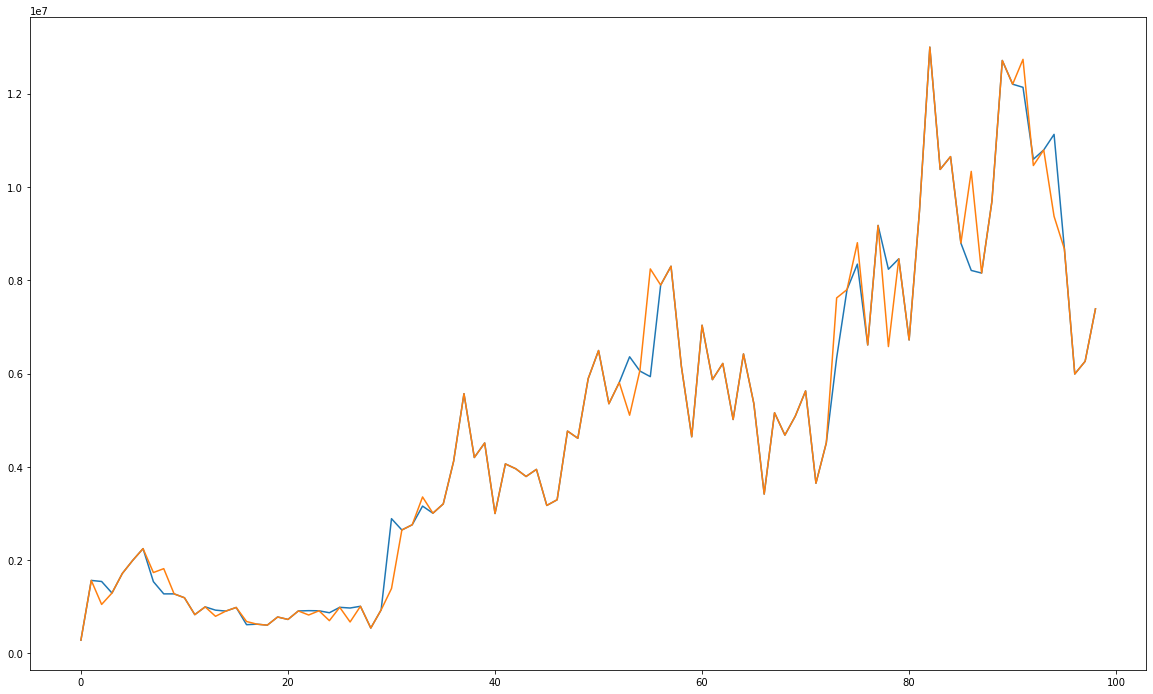

In [11]:
### Predict & plot
model.fit(X_train, y_train)
y_pred = model.predict(X)
y = y.reset_index(drop=True)

y_pred = np.array(y_pred).tolist()

plt.figure(figsize=(20,12))
plt.plot(y_pred)
plt.plot(y)

### Check Error Scores

#Accuracy
abs_error = abs(y - y_pred)
accuracy = 1 - abs_error.sum()/y.sum()
# google_mae = mean_absolute_error(y_true=df_test['revenue'],
#                    y_pred=df_test['revenue_pred'])
# df_mse = mean_squared_error(y_true=df_test['revenue'],
#                    y_pred=df_test['revenue_pred'])
df_mape = mean_absolute_percentage_error(y_true=y,
                               y_pred=y_pred)

print('Accuracy {}'.format(accuracy))
print('R2 {}'.format(r2_score(y, y_pred)))
# print('MAE: {}'.format(google_mae))
# print('MSE: {}'.format(df_mse))
print('MAPE: {}'.format(df_mape))
# print('RMSE: {}'.format(df_rmse))

### Forecasting Ahead

In [12]:
budget = pd.read_csv("data.csv")
budget['date'] = pd.to_datetime(budget['date'])
budget.head()

,date,display,social,search,tv,promo
0,2023-05-01,4570,3608,7018,0,0
1,2023-05-02,4638,4173,7626,0,1
2,2023-05-03,5763,4131,6823,0,0
3,2023-05-04,5182,4236,6706,0,0
4,2023-05-05,5112,3975,6141,0,0


In [13]:
## get week
weekstart = []
for i in budget['date']:
    weekstart.append(this_monday(i))

budget['week'] = weekstart

##group by week
budget_sum=pd.pivot_table(budget, index=['week'], values=['display','social','search'],aggfunc=np.sum)
budget_max=pd.pivot_table(budget, index=['week'], values=['tv','promo'],aggfunc=np.max)
budget = pd.merge(budget_sum, budget_max, left_index=True, right_index=True)

##add time series features
budget['week'] = budget.index
budget['week'] = pd.to_datetime(budget.week, format='%Y-%m-%d')
budget['year'] = budget['week'].dt.year
budget['year'] = budget['year']-2020
# budget['quarter'] = budget['week'].dt.quarter
# budget['month'] = budget['week'].dt.month
# budget['weekofyear'] = budget['week'].dt.isocalendar().week
budget = budget.drop(columns = 'week')

# budget = budget.drop(columns = ['tv','promo'])
budget.head()

,display,search,social,promo,tv,year
week,,,,,,
2023-05-01,34600,46995,28778,1,0,3
2023-05-08,34600,51760,33480,0,0,3
2023-05-15,34600,53760,37646,0,1,3
2023-05-22,34600,53760,37646,1,1,3
2023-05-29,36001,77988,37646,1,0,3


In [14]:
revenue_pred_features = pd.DataFrame()
revenue_pred_features['revenue_pred'] = model.predict(budget)

pred_index = budget.index
revenue_pred_features = revenue_pred_features.set_axis(pred_index)

revenue_pred_features.head()

,revenue_pred
week,
2023-05-01,7.041555e+06
2023-05-08,7.245702e+06
2023-05-15,7.778211e+06
2023-05-22,7.706535e+06
2023-05-29,9.909451e+06


#### Ploting

<AxesSubplot:xlabel='week'>

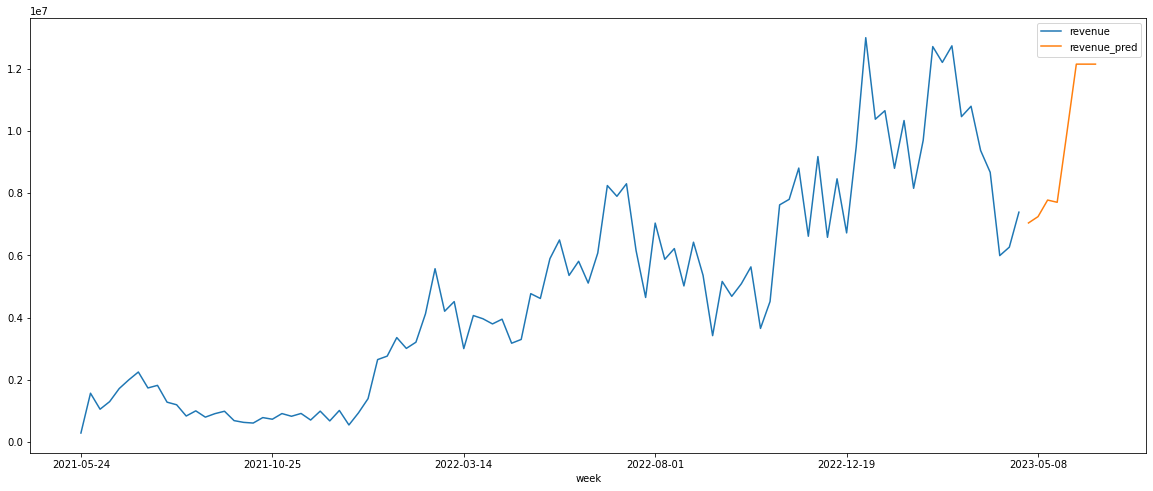

In [15]:
df_all = pd.concat([df[['revenue']], revenue_pred_features[['revenue_pred']]])

df_all[['revenue','revenue_pred']].plot(figsize=(20, 8))

In [16]:
##validate
validate = pd.read_csv("data.csv")
validate.rename(columns = {'revenue':'revenue_validate'}, inplace = True)

## get week
validate['date'] = pd.to_datetime(validate.date)
weekstart = []
for i in validate['date']:
    weekstart.append(this_monday(i))

validate['weekstart'] = weekstart

##group by week
validate=pd.pivot_table(validate, index=['weekstart'], values=['display','social','search','revenue_validate'],aggfunc=np.sum)

from sklearn.metrics import mean_absolute_percentage_error
revenue_pred_features = revenue_pred_features[:6]
mean_absolute_percentage_error(validate['revenue_validate'],revenue_pred_features)

0.12534826767755294

In [17]:
validate['revenue_validate']

weekstart
2023-05-01    7286344.45
2023-05-08    6424735.17
2023-05-15    7599177.26
2023-05-22    7161618.06
2023-05-29    9278517.80
2023-06-05    8537145.53
Name: revenue_validate, dtype: float64

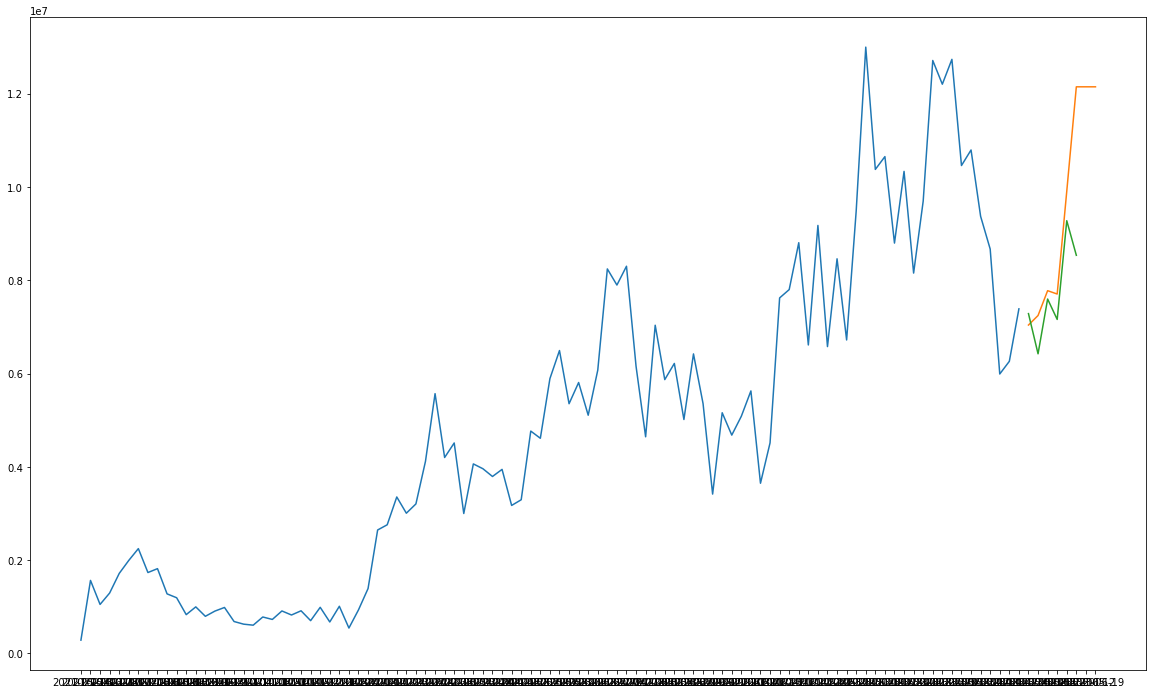

Accuracy 0.8696754828893166
R2 -1.742795615542311
MAE: 1005400.1788800043
MAPE: 0.12534826767755294


In [18]:
# df_all.index = pd.to_datetime(df_all.index, format='%Y/%m/%d %H:%M:%S.%f')
# validate.index = pd.to_datetime(validate.index, format='%Y/%m/%d')
plt.figure(figsize=(20,12))
plt.plot(df_all)
plt.plot(validate['revenue_validate'])

plt.show()
# df_all['week'] = df_all.index
# sns.lineplot(data = df_all,x='week', y='revenue')
# sns.lineplot(data = df_all,x='week', y='revenue_pred')

abs_error = abs(validate['revenue_validate'] - df_all['revenue_pred'])
accuracy = 1 - abs_error.sum()/validate['revenue_validate'].sum()

print('Accuracy {}'.format(accuracy))
print('R2 {}'.format(r2_score(validate['revenue_validate'],revenue_pred_features)))
print('MAE: {}'.format(mean_absolute_error(validate['revenue_validate'],revenue_pred_features)))
print('MAPE: {}'.format(mean_absolute_percentage_error(validate['revenue_validate'],revenue_pred_features)))

<AxesSubplot:xlabel='week'>

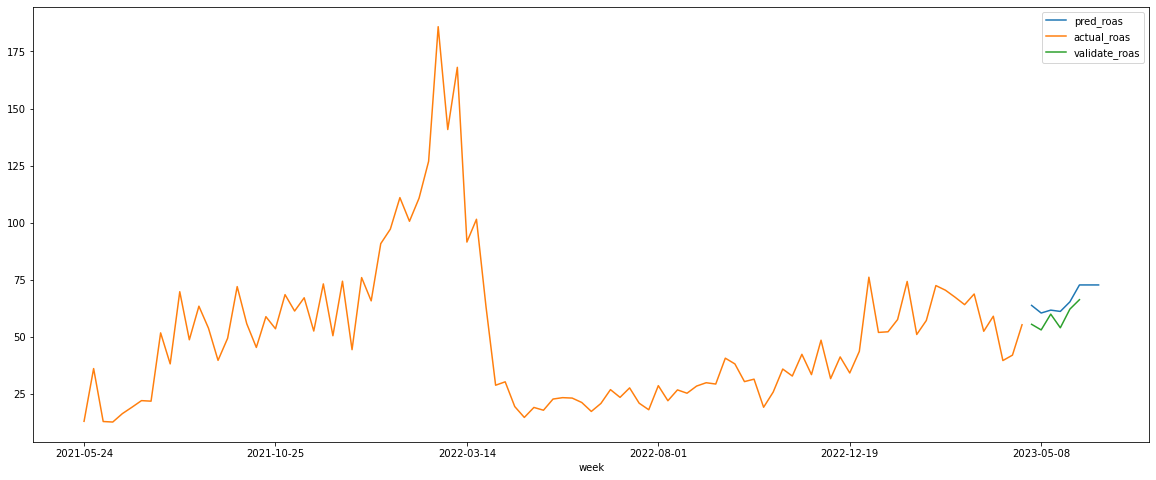

In [19]:
df['spend'] = df['display']+df['social']+df['search']
budget['budget'] = budget['display']+budget['social']+budget['search']
validate['validate_spend'] = validate['display']+validate['social']+validate['search']

# df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
# budget.index = pd.to_datetime(budget.index, format='%Y/%m/%d')
# validate.index = pd.to_datetime(validate.index, format='%Y/%m/%d')

df_all_2 = pd.merge(df_all,df['spend'],how='left',left_index = True,right_index=True )
df_all_2 = pd.merge(df_all_2,budget['budget'],how='left',left_index = True, right_index=True)
df_all_2 = pd.merge(df_all_2,validate['validate_spend'],how='left',left_index = True, right_index=True)
df_all_2 = pd.merge(df_all_2,validate['revenue_validate'],how='left',left_index = True, right_index=True)

df_all_2['pred_roas'] = df_all_2['revenue_pred']/df_all_2['budget']
df_all_2['actual_roas'] = df_all_2['revenue']/df_all_2['spend']
df_all_2['validate_roas'] = df_all_2['revenue_validate']/df_all_2['validate_spend']

df_all_2[['pred_roas','actual_roas','validate_roas']].plot(figsize=(20, 8))

In [20]:
abs_error = abs(df_all_2['validate_roas'] - df_all_2['pred_roas'])
print('Accuracy {}'.format(1 - abs_error.sum()/df_all_2['validate_roas'].sum()))
# print('R2 {}'.format(r2_score(df_all_2['pred_roas'],df_all_2['validate_roas'])))
# print('MAPE: {}'.format(mean_absolute_percentage_error(df_all_2['pred_roas'],df_all_2['validate_roas'])))

Accuracy 0.9024544751518546
